# Introduction

In this notebook, we demonstrate how to make connection to an OPC UA Server (Prosys UA Simulation Server in this case) using Python. We can then interactive with the UA server by reading and writing real-time data. 

To start, there is something you need to prepare in advance.
1. Install Python environment and the package "opcua" (We suggest you run <font color='red'><b>pip install opcua</b></font> in command prompt)
2. Install the OPC UA Server. In this case, you can download Prosys UA Server for free in the following URL<br>
<a href='https://www.prosysopc.com/products/opc-ua-simulation-server/'>https://www.prosysopc.com/products/opc-ua-simulation-server/</a>

# Sample Code
Below are sample codes to make OPC UA Server connection with Python language

## Server Connection

In [1]:
#First, import the opcua package
from opcua import ua,Client
import socket
import notebook.notebookapp
%matplotlib inline

#Find out the connection string of OPC UA Server and initiate client object, replace {} with OPC UA Server hostname
url ="opc.tcp://{}.localdomain:53530/OPCUA/SimulationServer".format(socket.gethostname())
client = Client(url)

#Connection to the OPC UA Server
client.connect()

## Explore OPC Hierachy (Nodes)
There are several nodes that have parent-children hierachy in OPC UA architecture, this section shows you how to explore the hierachy using Python opcua package.

By using get_root_node method, you can locate yourself at the top of the UA Server hierachy. You may use get_children method to search down the hierachy. Get_browse_name method allows you to view the browse name instead of nodeID of the node.

In [2]:
# Call get_root_node method to locate node at the top of hierachy
root_node = client.get_root_node()

# Use get_children to drill down the hierachy, get_browse_name method allows you to view node browse name instead of nodeID
[ x.get_browse_name() for x in root_node.get_children()]

[QualifiedName(0:Objects), QualifiedName(0:Types), QualifiedName(0:Views)]

In [3]:
# Locate object node where our variables are stored
objects = root_node.get_children()[0]

# Or you can use get_objects_node to directly locate objects node
objects = client.get_objects_node()

#Browse for the children nodes of the objects node
[ x.get_browse_name() for x in objects.get_children()]

[QualifiedName(0:Server),
 QualifiedName(0:Aliases),
 QualifiedName(3:Simulation),
 QualifiedName(5:StaticData),
 QualifiedName(6:MyObjects)]

In [4]:
# Use get_children method to explore children of the object node
# Use index to choose children node of desire 
sim_data_node = objects.get_children()[2]

#Apply get_browse_name to get node name instead of node id
[ {"NodeID":x ,"Node Name": x.get_browse_name()} for x in sim_data_node.get_children()]

[{'NodeID': Node(FourByteNodeId(ns=3;i=1001)),
  'Node Name': QualifiedName(3:Counter)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1002)),
  'Node Name': QualifiedName(3:Random)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1003)),
  'Node Name': QualifiedName(3:Sawtooth)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1004)),
  'Node Name': QualifiedName(3:Sinusoid)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1005)),
  'Node Name': QualifiedName(3:Square)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1006)),
  'Node Name': QualifiedName(3:Triangle)},
 {'NodeID': Node(FourByteNodeId(ns=3;i=1007)),
  'Node Name': QualifiedName(3:Test_Var)}]

If you already know the node index, you can directly reach the node by using get_node method.

In [5]:
# You may specify NodeId using NodeId object or string
# The two method below reaches the same node
from opcua.ua import NodeId
client.get_node(NodeId(1004,3)).get_browse_name()

# Get to specific node by specifying node index using get_node method
client.get_node('ns=3;i=1004').get_browse_name()

QualifiedName(3:Sinusoid)

## Read and write values
When you locate at the desired variable, you can now apply get_value and set_value method to read and write values. Just a reminder, you need to enable write access at server side before trying to write value from client.

In [6]:
#Index desired variable and apply get_value method to read value
sim_data_node_sin = client.get_node('ns=3;i=1004')
sim_data_node_sin.get_value()

-0.4158233

In [7]:
# Index desired variable and apply set_value method to write value
sim_data_node_test =  client.get_node('ns=3;i=1007')
print("The original value of {} is {}".format(sim_data_node_test.get_browse_name(), sim_data_node_test.get_value()))
sim_data_node_test.set_value(4.0)
print("The modified value of {} becomes {}".format(sim_data_node_test.get_browse_name(), sim_data_node_test.get_value()))



The original value of QualifiedName(3:Test_Var) is 4.0
The modified value of QualifiedName(3:Test_Var) becomes 4.0


## Real-Time Data Acquisition with Python opcua

In this section, we gather real-time data from our OPC UA simulation server and perform real-time plotting to visualize collected data.

<IPython.core.display.Javascript object>


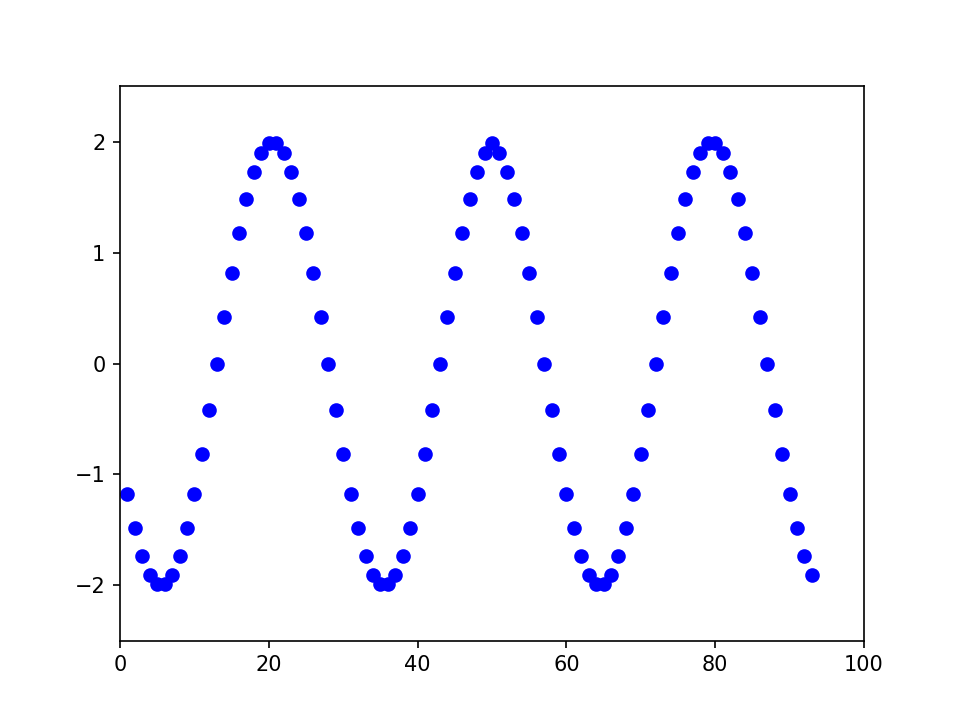

In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Activate interactive plotting in Jupyter Notebook
%matplotlib notebook 

#Initiate figure and ax objects
fig, ax = plt.subplots()
x, y = [], []
line, = ax.plot([], [], 'bo')

def init():
    """
    This init function defines the initial plot parameter
    """
    # Set initial parameter for the plot
    ax.set_xlim(0, 100)
    ax.set_ylim(-2.5, 2.5)
    return line,

def animate(frame):
    """
    This function will be called periodically by FuncAnimation. Frame parameter will be passed on each call as a counter. 
    """
    # Append data to x and y data list
    x.append(frame)
    y.append(sim_data_node_sin.get_value())
    
    # Adjust limit when step count exceeds certain number (100 in this case)
    limit =  max(100, max(x))
    ax.set_xlim(limit-100, limit)
    
    # Set data for line plot
    line.set_data(x, y)
    return line,

# Create FuncAnimation object and plt.show() to show the updated animation
ani = FuncAnimation(fig, animate, frames = np.linspace(1,1000,1000), interval=1000, init_func=init, blit=True)
plt.show()

In [9]:
client.close_session()

ServiceFault from server received  in response to ReadRequest


# Conclusion

We now understand how to explore OPC UA Server and read/write values with Python language. Of course, opcua package can also act as independent OPC UA Server, but in most cases, we would have a more sophiscated software with GUI instead. However, if you are interested in creating Server with opcua package, you may refer to this <a href='https://github.com/FreeOpcUa/python-opcua/blob/master/examples/server-example.py'>page</a> showing example code of building server.